In [67]:
import collections
import itertools
import re
import string
import timeit

import matplotlib.pyplot as plt
import nltk
#nltk.download('popular')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import sklearn

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

from utils.utils import *
from utils.topic_utils import *

In [95]:
stop_words = [*stopwords.words(),
              '<-url->', '<-@->', '<-#->', ]
tokenizer = TweetTokenizer(preserve_case=False,
                       reduce_len=True,
                       strip_handles=True)

## String processing

In [68]:
def long_string(list_of_strings):
    """
    Concatenate a list of strings into a single string.
    """
    return ' '.join([string for string in list_of_strings])

def long_list(list_of_lists):
    """
    Concatenate items from multiple lists into a single list.
    """
    return list(itertools.chain(*list_of_lists))

def preprocess_string(string, placeholders=False):
    """Remove symbols; replace urls, hashtags, and user 
       mentions with a placeholder token.
    """
    # "rt" ("retweet") 
    string = re.sub('rt', '', string.lower())
    
    if placeholders:
        # @-mentions
        string = re.sub(r'@\w+', '<-@->', string)

        # hyperlinks
        string = re.sub(r'http\S+', '<-URL->', string)
        string = re.sub(r'www.[^ ]+', '<-URL->', string)
    
        # hashtags
        string = re.sub(r'#\w+', '<-#->', string)
    else:
        # @-mentions
        string = re.sub(r'@\w+', '', string)

        # hyperlinks
        string = re.sub(r'http\S+', '', string)
        string = re.sub(r'www.[^ ]+', '', string)
    
        # hashtags
        string = re.sub(r'#\w+', '', string)
    
    # digits
    string = re.sub(r'[0-9]+', '', string)
    
    # symbols
    string = re.sub(r'[!"$%&()*+,./:;=?[\]^_`{|}~...]+', '', string)
    
    return string

def tokenize_string(input_string, tokenizer=TweetTokenizer(preserve_case=False,
                                                           reduce_len=True,
                                                           strip_handles=False)):
    """Preprocess and tokenize a raw tweet string.
    
    Args:
        in_string: string to tokenize
        tokenizer: object with a ``tokenize'' method for strings
        
    Return:
        tokens: list of strings (tokens)
    """
    preprocessed = preprocess_string(input_string)
    
    tokens = tokenizer.tokenize(preprocessed)
    
    # remove symbol-only tokens
    tokens = [t for t in tokens if not t in string.punctuation]
    
    return tokens

def remove_stopwords(tokens, stopword_list):
    """Remove unwanted words (``stop words'') from a list of string tokens.
    
    Args:
        tokens: list of tokens to filter
        stopword_list: list of words to remove
        
    Return:
        filtered_tokens: list of tokens with stop words removed
    """    
    cache = set(stopword_list)
    filtered_tokens = [token for token in tokens
                       if token.lower() not in cache]
    
    return filtered_tokens

def lemmatize(tokens, lemmatizer):
    """Lemmatize a set of tokens.
    
    Args:
        tokens: list of tokens to lemmatize
        lemmatizer: object with a ``lemmatize'' method for strings
        
    Return:
        lemmatized: list of lemmatized tokens
    """
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized

# Text processing

## Pipeline:
We are starting with a series of strings representing individual tweets. We can perform our analysis on
- individual tweets
- all tweets for a grouping of the dataframe (e.g. group by userid)
- all tweets in the corpus

In addition,
- hashtags and urls are already in a separate column, as a list of strings.

In general, we want to convert tweet text into tokens for analysis. We will make utility functions which anticipate tokenizing for these levels of analysis.

1. Individual tweets are strings; groups of tweets are lists of strings
1. Preprocessing:
    1. Remove uninformative symbols
    1. Remove 'RT'
    1. Replace urls, hashtags, and @-mentions with generic tokens
    1. Remove stopwords
    1. Lemmatize
1. Apply preprocessing to column of strings OR column of lists of strings
    - Treat column of strings as a single list of strings

In [6]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [7]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [8]:
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

### Pipeline usage

Series of strings:

In [9]:
tweet_series = campaign.loc[:]['tweet_text'].head(10)
tweet_series

tweetid
1271764746983952390    Tous ces gens qui s'en prennent à #Colbert alo...
907991739713118208     Why there's a bird sound? And why it's upside ...
1277789135470768129    Malawi is using bamboo to fight #climatechange...
137282411095539712                           terpikir terus bayanganmu..
1314271851988873251    😷Right in the middle of an illness😷 ..... #Bla...
1298084197773520898    Scotland’s Climate Assembly, doing politics di...
1229507901397618689                      wah.. lama gak buka twitter ini
141987801989251073                                            Tidur ah..
1291999805770694656    It's an urgent warning from climate scientists...
27210273549            Iya donks..RT @febianamalini: @c9mb6wqz2DoBkw5...
Name: tweet_text, dtype: string

In [10]:
t1 = default_timer()
processed = (tweet_series
             .apply(tokenize_string, tokenizer=tokenizer)
             .apply(remove_stopwords, stopword_list=stop_words)
             .apply(lemmatize, lemmatizer=WordNetLemmatizer())
            )
t2 = default_timer()
print('elapsed', t2 - t1)
processed

elapsed 1.067198777993326


tweetid
1271764746983952390    [tous, gen, s'en, prennent, alors, qu'ils, n'a...
907991739713118208                        [there's, bird, sound, upside]
1277789135470768129      [malawi, using, bamboo, fight, restore, admire]
137282411095539712                                [terpikir, bayanganmu]
1314271851988873251                       [😷, right, middle, illness, 😷]
1298084197773520898    [scotland, ’, climate, assembly, politics, dif...
1229507901397618689                                 [gak, buka, twitter]
141987801989251073                                           [tidur, ah]
1291999805770694656                [urgent, warning, climate, scientist]
27210273549             [iya, donks, wuuuiiihhh, dy, twiteran, hahahaha]
Name: tweet_text, dtype: object

Aggregation for tweet text can be defined as joining tweet strings into a list of strings:

In [11]:
string_agg = lambda x: list(x)

user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              ).head(10)
user_tweets

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,[America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,[People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an r...
1067814896706994176,[Inilah bentuk rasionalitas islam dan ketiadaa...
1091795789263921152,[اگه امشب مولانا توییتر میومد از همه مون راضی ...
1099221870530961408,"[Droit de vote à 16ans, vous êtes ?\nEt pourqu..."
1235289416370774016,[Trump has realized that he will be the loser ...


Processing a series of lists of strings:

In [12]:
tweets_series = user_tweets.loc[:]['tweet_text']
tweets_series

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [@VoteMarsha Why Women Prefer to Vote for an r...
1067814896706994176                             [Inilah bentuk rasionalitas islam dan ketiadaa...
1091795789263921152                             [اگه امشب مولانا توییتر میومد از همه مون راضی ...
1099221870530961408                             [Droit de vote à 16ans, vous êtes ?\nEt pourqu...
1235289416370774016                             [Trump has realized that he will be the loser ...
1273528131861782528                             [The Trumps have ruined our country and if ree...
Name: tweet_t

In [13]:
t1 = default_timer()

cache = stop_words
tokens_from_lists = (tweets_series
                    .apply(lambda x: [tokenize_string(el, tokenizer) for el in x])
                    # concatenate lists of tokens from all tweets
                    .apply(long_list)
                )
t2 = default_timer()
print('elapsed', t2 - t1)
tokens_from_lists

elapsed 3.4952837270102464


userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [america, and, the, way, its, government, trea...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [<-@->, اگه, ایران, به, یمن, و, مقاومت, کمک, ن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [people, are, not, silent, this, structure, mu...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [el, pueblo, indígena, kayapo, cerró, una, imp...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [<-@->, why, women, prefer, to, vote, for, an,...
1067814896706994176                             [inilah, bentuk, rasionalitas, islam, dan, ket...
1091795789263921152                             [اگه, امشب, مولانا, توییتر, میومد, از, همه, مو...
1099221870530961408                             [droit, de, vote, à, ans, vous, êtes, et, pour...
1235289416370774016                             [trump, has, realized, that, he, will, be, the...
1273528131861782528                             [the, trumps, have, ruined, our, country, and,...
Name: tweet_t

In [14]:
cache = set(stop_words)
tokens_per_user = (tokens_from_lists
              # remove stop words
            .apply(lambda x: [token for token in x
                                   if token.lower() not in cache])
            .apply(lambda x: [WordNetLemmatizer().lemmatize(token) for token in x])
            )
tokens_per_user

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [america, way, government, treat, people, must...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [اگه, ایران, یمن, و, مقاومت, کمک, نکنه, خاک, ت...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [people, silent, structure, must, change, hell...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [pueblo, indígena, kayapo, cerró, impoante, ca...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [woman, prefer, vote, rapest, pedophile, reall...
1067814896706994176                             [bentuk, rasionalitas, islam, ketiadaan, bentu...
1091795789263921152                             [اگه, امشب, مولانا, توییتر, میومد, از, همه, مو...
1099221870530961408                             [droit, vote, an, pourquoi, 🔴, quoi, neuf, ras...
1235289416370774016                             [trump, realized, loser, election, keep, pleas...
1273528131861782528                             [trump, ruined, country, reelected, country, d...
Name: tweet_t

### All tweets

In [69]:
string_agg = lambda x: list(x)

user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              ).loc[:]['tweet_text']
type(user_tweets)

pandas.core.series.Series

In [70]:
def make_tokens(string_series):
    t1 = default_timer()

    cache = set(stop_words)
    tokens = (string_series
                    # may take some time - TODO use better python list comprehension
                    .apply(lambda x: [tokenize_string(el, tokenizer) for el in x])
                    # concatenate lists of tokens from all tweets
                    .apply(long_list)
                    # remove stop words
                    .apply(lambda x: [token for token in x
                                   if token.lower() not in cache])
                    # lemmatize
                    .apply(lambda x: [WordNetLemmatizer().lemmatize(token) 
                                      for token in x])
                    )
    t2 = default_timer()
    print('elapsed', t2 - t1)
    
    return tokens

user_tokens = make_tokens(user_tweets)

elapsed 68.413830348989


In [71]:
user_tokens

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [america, way, government, treat, people, must...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [اگه, ایران, یمن, و, مقاومت, کمک, نکنه, خاک, ت...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [people, silent, structure, must, change, hell...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [pueblo, indígena, kayapo, cerró, impoante, ca...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [woman, prefer, vote, rapest, pedophile, reall...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     [good, look, tweet, agree, like, severe, hatre...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     [hapus, zionisme, hapus, penjajahan, israel, l...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      [karl, marx, leader, nothing, dems, asking, cr...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     [sick, tired, lied, amazing, go, vote, better,...
zk4khaX7A3XhX

## Frequency

In [16]:
def word_frequency(list_of_words):
    """
    Return:
        dict of {'word':'frequency'} sorted by frequency (high to low)
    """
    counts = collections.Counter(list_of_words)
    
    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

### All tweets

In [17]:
full_freq_dict = word_frequency(long_list(user_tokens))
full_freq_dict

{'…': 57903,
 'via': 40982,
 '’': 34702,
 'و': 32049,
 'completa': 25234,
 'trump': 22698,
 '‘': 21534,
 'irán': 18854,
 '“': 18755,
 'eeuu': 18730,
 'yang': 18359,
 '”': 17519,
 '\u200c': 16381,
 '،': 15993,
 'از': 15338,
 'video': 14405,
 'که': 14106,
 'در': 13904,
 'historia': 13126,
 '😂': 12427,
 'israel': 12272,
 'nota': 11551,
 'presidente': 11395,
 'people': 11171,
 'palestina': 9959,
 'gobierno': 9752,
 'silver': 9506,
 'biden': 9431,
 '؟': 9212,
 'را': 8810,
 'u': 8408,
 'این': 8281,
 'siria': 8102,
 'َ': 8006,
 'با': 7964,
 'iraní': 7619,
 'país': 7290,
 'uploaded': 6882,
 'ejército': 6880,
 'mueos': 6699,
 'است': 6268,
 'nuevo': 6135,
 'fuerzas': 5988,
 'added': 5639,
 'ataque': 5634,
 'terroristas': 5628,
 'militar': 5510,
 'president': 5476,
 'playlist': 5423,
 'crisis': 5318,
 'رو': 5235,
 'vote': 5222,
 'orang': 5211,
 'price': 5152,
 'amp': 5115,
 'china': 5075,
 'pide': 5067,
 'xttxkplli': 5019,
 'american': 4961,
 'tras': 4951,
 'acuerdo': 4943,
 'guerra': 4882,
 'yea

## Word cloud

In [18]:
def visualize(data,
              from_frequencies=True,
              limit=100,
              color=(150,50,50)):
    """
    """
    cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:color)
    
    data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
    
    if from_frequencies:
        cloud.generate_from_frequencies(data)
    else:
        cloud.generate(data)
    
    fig, ax = plt.subplots()
    ax.imshow(cloud)
    ax.axis('off')
    
    return fig

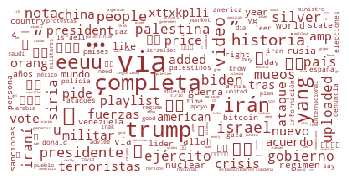

In [19]:
# todo: render arabic
fig = visualize(full_freq_dict)

## Vectorizing

Using sklearn's Vectorizers to turn the corpus into a text-term matrix allows us to easily count tokens, and count n-grams as well as single-word tokens.

In [20]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [98]:
def ngram_freq_matrix(strings_series,
                      stop_words=None,
                      ngram_range=(1,2)):
    """
    Args: 
       list_of_strings: iterable of strings
       stop_words: a list of stop words or the string 'english' to use a
                   built-in English language stop word list.
                   Default: no stop words
       ngram_range: a single int, or a 2 tuple representing the range of ngrams to count.
                    Default: (1,2); counts 1- and 2- grams.
    Return:
       dataframe of counts indexed by n-gram
    """
    vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=[*stopwords.words(),
                                              '<-url->', '<-@->', '<-#->', ],
                                 ngram_range=ngram_range,
                                 tokenizer=TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True).tokenize
                                )
    
    ngram_freq_matrix = vectorizer.fit_transform(strings_series)
    ngrams = vectorizer.get_feature_names()

    ngram_frequencies = ngram_freq_matrix.sum(axis=0).tolist()[0]
    freq_dict = dict(zip(ngrams, ngram_frequencies))
    
    return ngram_freq_matrix, (pd.Series(freq_dict)
                              .sort_values(ascending=False))

In [99]:
user_tokens_list = long_list(user_tokens)
matrix, words = ngram_freq_matrix(user_tokens_list)
matrix

/home/sarah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", '-', '.', '?', '^', 'acaba', 'acesti', 'aiba', 'altal', 'altalaban', 'altms', 'amig', 'arasnda', 'arrol', 'artq', 'aslnda', 'astia', 'ate', 'aveti', 'avra', 'avro', 'azert', 'aztan', 'azutan', 'bade', 'bae', 'bar', 'baz', 'bel', 'belul', 'bes', 'bilr', 'birkac', 'birsey', 'bizlr', 'blk', 'bos', 'brzcas', 'brzkone', 'bunlarn', 'butun', 'bzi', 'bzn', 'caci', 'carei', 'caror', 'carui', 'cate', 'cati', 'catva', 'cem', 'cemer', 'cemerkoli', 'cemu', 'cemur', 'cemurkoli', 'ceprav', 'ceravno', 'cesa', 'cesar', 'cesarkoli', 'cetrta', 'cetrte', 'cetrtega', 'cetrtem', 'cetrtemu', 'cetrti', 'cetrtih', 'cetrtim', 'cetrtima', 'cetrtimi', 'cetrto', 'cetudi', 'cez', 'cezenj', 'ceznje', 'cigar', 'cigav', 'cigava', 'cigave', 'cigavega', 'cigavem', 'cigavemu', 'cigavi', 'cigavih', 'cigavim', 'ci

<4904294x136568 sparse matrix of type '<class 'numpy.int64'>'
	with 3778104 stored elements in Compressed Sparse Row format>

In [100]:
words[:20]

...           57903
via           45596
completa      25234
trump         22700
iran          22458
eeuu          18729
yang          18361
video         16048
historia      13126
israel        12315
nota          11551
presidente    11398
people        11172
palestina      9959
gobierno       9752
silver         9506
biden          9431
siria          8101
irani          7630
pais           7309
dtype: int64

# Topic extraction

Tutorial: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#

In [38]:
# suggested scale
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [39]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model which models a corpus as a random mixture of topics and uses the observed words to fit latent variables describing the mixture of topics and the distribution of words in the documents of the corpus.

A corpus consists of $D$ documents ($\sim$vector samples) of $N$ words ($\sim$entry samples) described by $K$ topics ($\sim$classes).

1. For each topic $k \in K$, draw $\beta_{k} \sim \text{Dirichlet}(\eta)$. This represents the probability of a word appearing in topic $k$.


1. For each document $d \in D$: draw the topic proportions $\theta_{d} \sim \text{Dirichlet}(\alpha).$

1. For each word $i$ in document $D$:
    1. Draw the topic assignment $z_{di} \sim \text{Multinomial}(\theta_{d})$
    2. Draw the observed word $w_{ij} \sim \text{Multinomial}(\beta_{z_{di}})$

For parameter estimation, the posterior distribution is:
$$
p(z,\theta,\beta\mid w,\alpha,\eta) = \frac{p(z,\theta,\beta\mid\alpha,\eta)}{p(w\mid\alpha,\eta)}
$$

Variational Bayesian method uses a simpler distribution to approximate the posterior distribution and optimizes parameters in an expectation-minimization procedure. Here the variational parameters $\lambda, \phi, \gamma$ are optimized to maximize the Evidence Lower Bound (ELBO) - maximizing ELBO is equivalent to minimizing the Kullback-Leibler(KL) divergence between $q$ and the true posterior $p$.

In [106]:
user_tokens = user_tweets.map(long_string)
user_tokens

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     America and the way its government treats its ...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    @ManotoNews اگه ایران به یمن و مقاومت کمک نکنه...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    People are not silent! This structure must cha...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     El pueblo indígena Kayapo cerró una importante...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    @VoteMarsha Why Women Prefer to Vote for an ra...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     Take a good look at #Trump and tweet me if you...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     Hapus zionisme hapus penjajahan.\n#Palestine\n...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      Karl Marx is the leader of These Do nothing De...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     I am sick and tired of being lied to by #realD...
zk4khaX7A3XhX

In [113]:
vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=[*stopwords.words(),
                                              '<-url->', '<-@->', '<-#->', ],
                                 ngram_range=(1,2),
                                 preprocessor=preprocess_string,
                                 tokenizer=TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True).tokenize
                                )
t1 = default_timer()

# using tweet aggregates for each user as the document-level
# object of analysis
tf = vectorizer.fit_transform(user_tokens)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

/home/sarah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", '-', 'ainya', 'azé', 'aıq', 'beanya', 'beanya-tanya', 'berai', 'beurut', 'beurut-turut', 'beutur', 'dipeanyakan', 'ezé', 'foae', 'fuher', 'mempeanyakan', 'mié', 'onların', 'peama', 'peama-tama', 'peanyaan', 'peanyakan', 'printr', 'sepei', 'sepeinya', 'teentu', 'teuju', 'vae', 'vee', 'vo', 'vå', 'væ', 'četa', 'čete', 'četega', 'četem', 'četemu', 'četi', 'četih', 'četim', 'četima', 'četimi', 'četo', 'δ', 'δι', 'агар-чи', 'аз-баски', 'афташ', 'бале', 'баҳри', 'болои', 'валекин', 'вақте', 'вуҷуди', 'гар', 'гарчанде', 'даме', 'карда', 'кошки', 'куя', 'кӣ', 'магар', 'майлаш', 'модоме', 'нияти', 'онан', 'оре', 'рӯи', 'сар', 'тразе', 'хомш', 'хуб', 'чаро', 'чи', 'чунон', 'шарте', 'қадар', 'ҳай-ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳой-ҳой', 'ҳол', 'ҳолате', 'ӯим', 'ँ', 'ं', 'ः', 'अक', 'अग', 

elapsed: 38.418309789005434


In [114]:
print(('n_samples: {}\nn_features: {}')
      .format(n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t1 = default_timer()

lda.fit(tf)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

n_samples: 2000
n_features: 1000
elapsed: 40.20263894999516


Results with sklearn preprocessing applied by CountVectorizer:

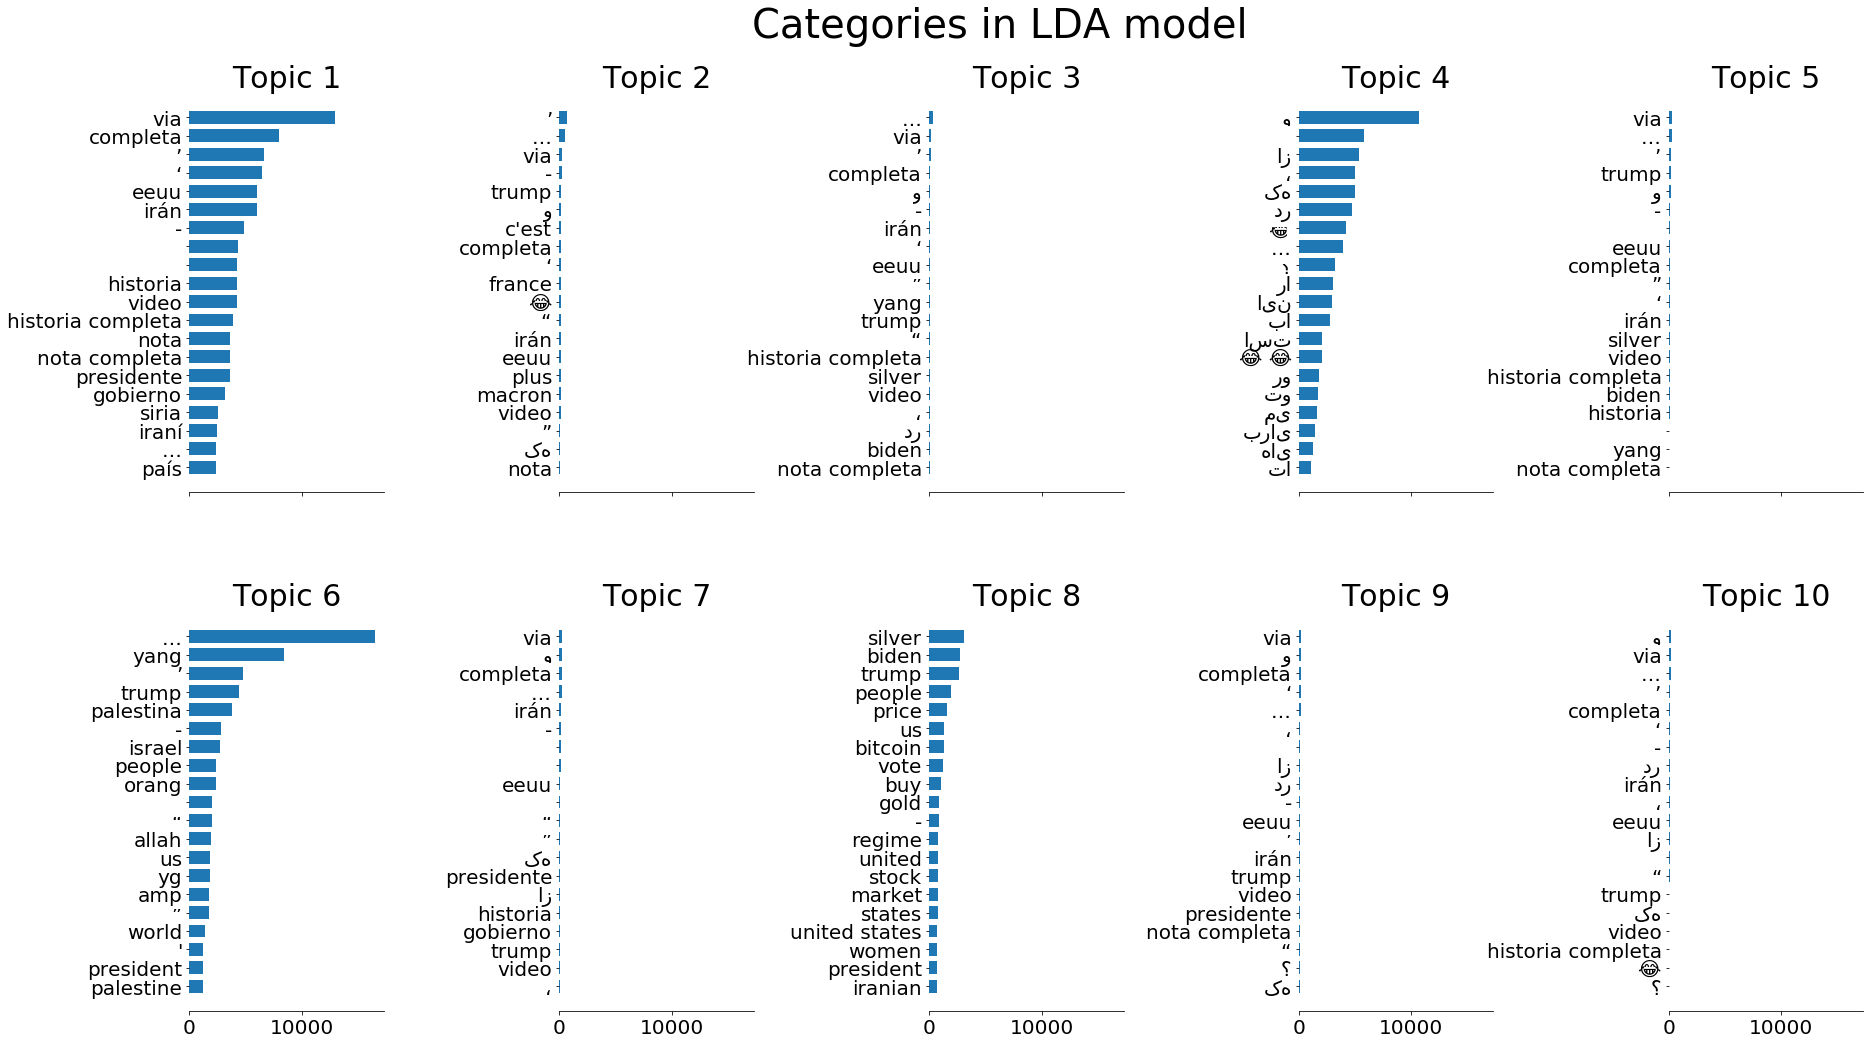

<Figure size 432x288 with 0 Axes>

In [115]:
tf_feature_names = vectorizer.get_feature_names()

plot_top_words(lda, 
               tf_feature_names, 
               n_top_words, 
               'Categories in LDA model')
plt.tight_layout()

Because the "document" level used in this case was per-user tweet token aggregates, we can perhaps consider these topics to be analogous to categories of users, based on their overall tweet set. Considering this campaign was so long, it is likely that the specific topics of tweets changed over time, so in further analysis, we might perform more filtering of the tweets in advance of clustering, for instance isolating tweets from a certain period of time.

In [116]:
def extract_topics(documents,
                   n_samples = 2000,
                   n_features = 1000,
                   n_components = 10,
                   n_top_words = 20,
                   preprocessing=True):
    
    if preprocessing:
        processed_documents = (documents
                             .map(long_string)
                             .map(preprocess_string)
                              )
    
    vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=[*stopwords.words(),
                                              '<-url->', '<-@->', '<-#->', ],
                                 ngram_range=(1,2),
                                 preprocessor=(preprocess_string 
                                               if preprocessing == False else None),
                                 tokenizer=TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True).tokenize
                                )

    tf = vectorizer.fit_transform(processed_documents)
    
    print(('n_samples: {}\nn_features: {}')
          .format(n_samples, n_features))

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf)
    
    tf_feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, 
                   tf_feature_names, 
                   n_top_words, 
                   'Categories in LDA model')
    plt.tight_layout()

Results with preprocessing outside of CountVectorizer:

/home/sarah/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'", '-', '.', '?', '^', 'acaba', 'acesti', 'aiba', 'altal', 'altalaban', 'altms', 'amig', 'arasnda', 'arrol', 'artq', 'aslnda', 'astia', 'ate', 'aveti', 'avra', 'avro', 'azert', 'aztan', 'azutan', 'bade', 'bae', 'bar', 'baz', 'bel', 'belul', 'bes', 'bilr', 'birkac', 'birsey', 'bizlr', 'blk', 'bos', 'brzcas', 'brzkone', 'bunlarn', 'butun', 'bzi', 'bzn', 'caci', 'carei', 'caror', 'carui', 'cate', 'cati', 'catva', 'cem', 'cemer', 'cemerkoli', 'cemu', 'cemur', 'cemurkoli', 'ceprav', 'ceravno', 'cesa', 'cesar', 'cesarkoli', 'cetrta', 'cetrte', 'cetrtega', 'cetrtem', 'cetrtemu', 'cetrti', 'cetrtih', 'cetrtim', 'cetrtima', 'cetrtimi', 'cetrto', 'cetudi', 'cez', 'cezenj', 'ceznje', 'cigar', 'cigav', 'cigava', 'cigave', 'cigavega', 'cigavem', 'cigavemu', 'cigavi', 'cigavih', 'cigavim', 'ci

n_samples: 2000
n_features: 1000


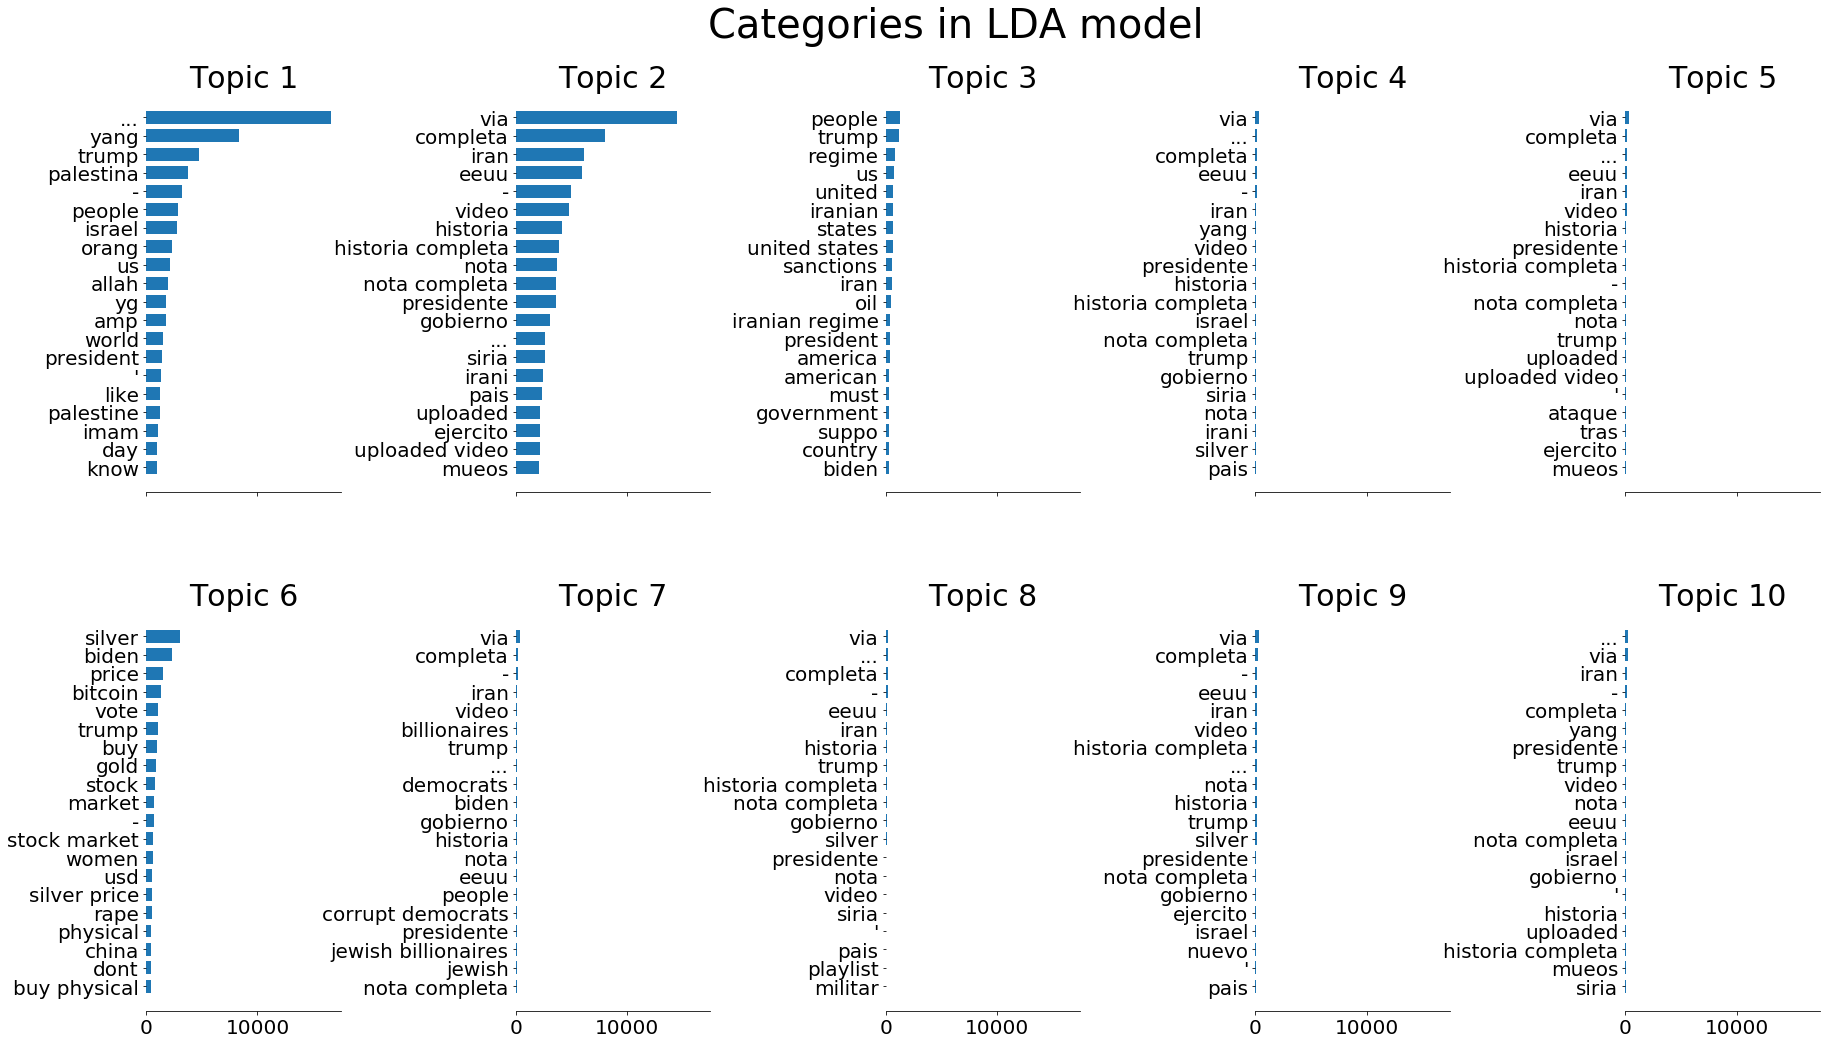

<Figure size 432x288 with 0 Axes>

In [117]:
extract_topics(user_tweets)

In [49]:
"""Variational parameters for topic word distribution. 

Since the complete conditional for topic word distribution is a 
Dirichlet, components_[i, j] can be viewed as pseudocount that 
represents the number of times word j was assigned to topic i. 
It can also be viewed as distribution over the words for each 
topic after normalization: 
model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
"""
lda.components_

array([[  5.52691865,   5.52653404,  26.15895585, ...,  15.30869566,
         12.86012831,   7.05567606],
       [  3.63738375,   5.03190241,  19.70179931, ...,   3.62407356,
          9.73769065,   2.39758555],
       [ 22.405746  ,  17.96929934, 106.82764246, ...,  74.21901463,
         99.44135671,  20.25001715],
       ...,
       [  2.4265769 ,   4.39567293,  10.12995946, ...,   2.50179456,
          3.4195851 ,   1.37666869],
       [  7.18022866,  13.25437163,  53.1393001 , ...,   0.71234894,
          1.08866624,   0.75748855],
       [  3.14346583,   3.10379637,  12.01736471, ...,   2.89629427,
          3.92496384,   1.13652243]])

### To do:
- mixtures of languages in topics?